# 確率ロボティクス2017第12回

上田隆一

2017年12月6日@千葉工業大学

## 今日やること

* SLAMとは何か
* FastSLAM

## SLAM

* SLAM（simultaneous localization and mapping）
  * 自己位置推定と地図生成を同時に行う方法
 

## SLAM問題

* 次のような地図$m^*$とロボットの軌跡$x^*{0:t}$を求める問題
  * $m^*,x^*_{0:t} = \text{argmax}_m P(m,x_{0:t} |u_{1:t}, z_{1:t})$
    * $x_{0:t}$: 行動のシーケンス$（x_0,x_1,x_2,...,x_t）$
    * $u_{1:t}$: センサ情報のシーケンス$（u_1,u_2,u_3,...,u_t）$
    * $z_{1:t}$: センサ情報のシーケンス$（z_1,z_2,z_3,...,z_t）$
      * （面倒なのでベクトルも細字で書いてます） 

## SLAMの基本手続き

* これで地図ができる （2次元の例, 距離センサを想定）
  * 最初のロボットの位置$x_0$（絶対座標）を$ (x,y,\theta) = (0,0,0)$とする
  * 以下の繰り返し
    * センサで障害物の位置を計測
    * 障害物の位置を絶対座標に変換して記録
    * ロボットを動かしてロボットの座標を更新
* 問題
  * 移動誤差、センサの雑音


## 確率を使わない実装

* 日経Linux 2015年11月号の上田の記事より

<img width="300" src="env.png" />
<img width="300" src="map-300x300.png" />

## 誤差への対応

* ベイズフィルタ
  * 主にオンラインSLAMで利用される
* 最小二乗法
  * 主にオフラインSLAMで利用される
* オンライン/オフライン
  * オンライン: ロボットが自己位置と地図を動いている途中に特定していく
  * オフライン: デッドレコニングとセンサ情報を全て記録しておいて後から地図と移動軌跡を特定

## FastSLAM

* オンラインSLAMの代表的な手法
* MCL + 地図の推定
* 1.0と2.0がある
  * 1.0をこれから実装
    * MCLのコードをコピーしながら作っていきましょう

### 地図のシミュレーション

In [1]:
%matplotlib inline
import numpy as np
from copy import copy
import math, random
import matplotlib.pyplot as plt                   #   for plotting data
from matplotlib.patches import Ellipse      #  for drawing

#### ランドマークのクラス

* 変数
  * ランドマークの位置（$\boldsymbol{m}_i$）
* メソッド
  * 描画
  * ロボット座標系でのランドマークの距離と方角を求める関数
    * 距離: $\sqrt{(x_m - x_r)^2 + (y_m - y_r)^2}$
    * 方角: $\text{atan2}(y_m - y_r,x_m - x_r) - \theta_r$
      * ただし
        * ランドマークの位置: $\boldsymbol{m}_i=(x_m,y_m)$
        * ロボットの真の姿勢: $\boldsymbol{x}=(x_r,y_r,\theta_r)$
   



In [2]:
class Landmark:
    def __init__(self,x,y):
        self.pos = np.array([[x],[y]])
        
    def draw(self):
        plt.scatter(xs,ys,s=300,marker="*",label="landmarks",color="orange")
        
    def relative_pos(self,pose):
        x,y,theta = pose
        lx,ly = self.pos[0][0],self.pos[1][0]
        distance = math.sqrt((x -lx)**2 + (y-ly)**2)
        direction = math.atan2(ly-y, lx-x) - theta
    
        return (distance, direction,lx,ly) #lx, lyを返すのは描画のため

#### 地図のクラス

地図 = 複数のランドマークの座標の集合と考える

$\boldsymbol{m} = \{\boldsymbol{m}_i | i=1,2,3,\dots,M\}$

* 変数
  * Landmarkのリスト
* メソッド
  * ランドマークの座標の追加
  * 描画
  * ロボット座標系での複数のランドマークの位置（極座標）を返す関数

In [3]:
class Map():
    def __init__(self):
        self.landmarks = []
        
    def append_landmark(self,x,y):
        self.landmarks.append(Landmark(x,y))
        
    def draw(self):
        xs = [ e.pos[0] for e in self.landmarks]
        ys = [ e.pos[1] for e in self.landmarks]
        plt.scatter(xs,ys,s=300,marker="*",label="landmarks",color="orange")
            
        
    def relative_landmark_positions(self,pose):
        positions = []
        for i,ln in enumerate(self.landmarks):
            distance,direction,lx,ly = ln.relative_pos(pose)
            positions.append([distance,direction,lx,ly,i])
        
        return positions
    

#### 正解の地図$\boldsymbol{m}^*$を作る

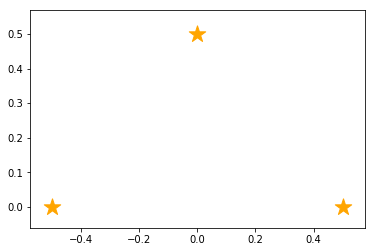

In [4]:
m = Map()
m.append_landmark(-0.5,0.0)
m.append_landmark(0.5,0.0)
m.append_landmark(0.0,0.5)

m.draw()

### ロボットのシミュレーション

#### ロボットのクラス

* 変数
  * 姿勢
* メソッド
  * 描画
  * 観測
    * ロボット座標系での正確な座標を引数でとって雑音を混ぜて返す
      * 観測した方向に距離の10%のノイズ
      * 観測した方向と垂直な方向に$距離\times\sin(5[\text{deg}])$のノイズ
    * SLAMに使われる変数
      * グローバル座標系での位置$\boldsymbol{z} = (x_z,y_z)$
      * $\boldsymbol{z}$の共分散行列$Q$
        * $Q$はノイズから計算される
  * 状態遷移関数
    * ロボットの移動後の座標を雑音付きで返す
      * MCLの実装を参考のこと

In [5]:
class Robot:
    def __init__(self,pose):
        self.pose = pose
        
    def draw(self):
        x,y,theta = self.pose
        plt.quiver([x],[y],[math.cos(theta)],[math.sin(theta)],color="red",label="actual robot motion")
        
    def observation(self,m):
        measurements = m.relative_landmark_positions(self.pose)
        observations = []
        
        for m in measurements:
            distance, direction,lx,ly, i = m
            # 方向の制限（cosの値が正）
            if (math.cos(direction) < 0.0): continue
    
            measured_distance = random.gauss(distance,distance*0.1)  
            measured_direction = random.gauss(direction,5.0/180.0*math.pi)
            observations.append([measured_distance, measured_direction,lx,ly,i])  
        
        return observations
    
    def motion_model(self, pos, fw, rot):
        actual_fw = random.gauss(fw,fw/10)    #標準偏差にしてfwの10%だけ移動距離に雑音を入れる
        dir_error = random.gauss(0.0, math.pi / 180.0 * 3.0) # 前進時にロボットの進路が曲がる雑音。標準偏差3[deg] 

        px, py, pt = pos

        #前進させる
        x = px + actual_fw * math.cos(pt + dir_error)
        y = py + actual_fw * math.sin(pt + dir_error)

        #回転。回転角にもrotの10%だけ雑音を入れる
        t = pt + dir_error + random.gauss(rot,rot/10)

        return np.array([x,y,t])

#### ロボットを環境に置いてみましょう

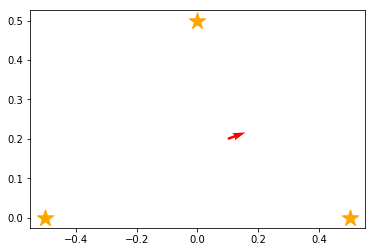

In [6]:
robot = Robot(np.array([0.1,0.2,math.pi*20.0/180]) )
robot.draw()
m.draw()

#### ロボットとランドマークの位置関係、観測についてデバッグ

と言ってもデバッグするのもコードが多くて大変ですが・・・

[[0.4554446499938928, -0.82505417366667522, 0.5, 0.0, 1], [0.32510708093748686, 1.6421320788104026, 0.0, 0.5, 2]]


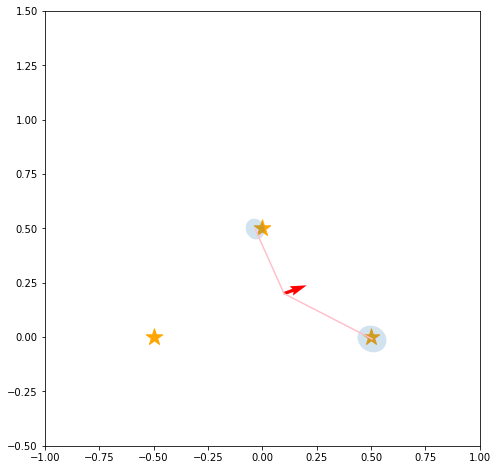

In [7]:
### ここの区画のコードは消去してもSLAMが動きます ###
observations = robot.observation(m)
print(observations)

fig = plt.figure(0,figsize=(8, 8))
sp = fig.add_subplot(111, aspect='equal')
sp.set_xlim(-1.0,1.0)
sp.set_ylim(-0.5,1.5)
    
for observation in observations:
    x,y,theta = robot.pose
    distance, direction,lx,ly, i = observation
    lx = distance*math.cos(theta + direction) + x
    ly = distance*math.sin(theta + direction) + y
    plt.plot([robot.pose[0],  lx],[robot.pose[1],  ly],color="pink")
    
    c = math.cos(theta + direction)
    s = math.sin(theta + direction)
    rot = np.array([[c, -s],
                    [s,  c]])
    
    err_robot = np.array([[(distance*0.1)**2,0.0],
              [0.0,(distance*math.sin(5.0/180.0*math.pi))**2]])
    err_world = (rot).dot(err_robot).dot((rot).T)
    
    eig_vals,eig_vec = np.linalg.eig(err_world)
    v1 = eig_vals[0] * eig_vec[:,0]
    v2 = eig_vals[1] * eig_vec[:,1]
    v1_direction = math.atan2(v1[1],v1[0])
    
    elli = Ellipse([lx,ly],width=3*math.sqrt(np.linalg.norm(v1)),height=3*math.sqrt(np.linalg.norm(v2)),angle=v1_direction/3.14*180)
    elli.set_alpha(0.2)
    sp.add_artist(elli)
    
robot.draw()
m.draw()

### FastSLAMの実装

#### ランドマークの推定結果の入れ物

* ランドマークの位置$\hat{\boldsymbol{m}_i}$
* 不確かさの共分散$\Sigma_i$

In [8]:
class LandmarkEstimation():
    def __init__(self):
        self.pos = np.array([[0.0],[0.0]])
        self.cov = np.array([[1000000000.0**2,0.0],
                            [0.0,1000000000.0**2]])    #最初は大きな共分散を持たせておく

#### パーティクル

* 変数
  * 重み
  * ロボットの姿勢
  * 地図
* メソッド
  * 動作をパーティクルに反映
    * MCLと同じ
  * 計測値をパーティクルに反映
    * 重みの計算
      * MCLと同じ
    * 地図の更新
      * $\Sigma_i \longleftarrow (\Sigma_i^{-1} + Q_z^{-1})^{-1}$
      * $K \longleftarrow \Sigma_i Q_z^{-1}$
      * $\hat{m_i} \longleftarrow (1-K)\hat{m_i} + K\boldsymbol{z}$
  * 描画

In [9]:
class Particle():
    def __init__(self,pose,w):
        self.w = w
        self.pose = pose
        self.map = [LandmarkEstimation(),LandmarkEstimation(),LandmarkEstimation()] #数は3で既知とする

    def motion_update(self, fw, rot, robot):
        self.pose = robot.motion_model(self.pose, fw, rot)
        
    def measurement_update(self, measurement):
        x,y,theta = self.pose
        distance, direction,lx,ly,i = measurement
        ln = self.map[i]
        lx = distance*math.cos(theta + direction) + x
        ly = distance*math.sin(theta + direction) + y
        ## 重みの更新
        delta = np.array([[x],[y]]) - np.array([[lx],[ly]])
        coef = 2*math.pi * math.sqrt(np.linalg.det(ln.cov))
        inexp = -0.5 * (delta.T.dot(np.linalg.inv(ln.cov))).dot(delta)
        self.w *= 1.0/coef * math.exp(inexp)
        
        ## 地図の書き換え
        z = np.array([[lx],[ly]])
    
        c = math.cos(theta + direction)
        s = math.sin(theta + direction)
        rot = np.array([[c, -s],
                        [s,  c]])
    
        err_robot = np.array([[(distance*0.1)**2,0.0],
                            [0.0,(distance*math.sin(5.0/180.0*math.pi))**2]])
        err_world = (rot).dot(err_robot).dot((rot).T)  # Q
        
        K = ln.cov.dot(np.linalg.inv(ln.cov + error_world))
        ln.pos += K.dot( z - ln.pos)
        ln.cov = (np.identity(2) - K).dot(ln.cov)
        
     #   ln.cov = np.linalg.inv( np.linalg.inv(ln.cov) + np.linalg.inv(err_world) )
     #   K = (ln.cov).dot(np.linalg.inv(err_world))
     #   ln.pos += K.dot( z - ln.pos )
        
    def draw(self,i,robot=None):
        fig = plt.figure(i,figsize=(4, 4))
        sp = fig.add_subplot(111, aspect='equal')
        sp.set_xlim(-1.0,1.0)
        sp.set_ylim(-0.5,1.5)
        
        m.draw()
        x,y,theta = self.pose
        plt.quiver([x],[y],[math.cos(theta)],[math.sin(theta)],color="red",label="estm. robot pos")
        if robot != None:
            x,y,theta = robot.pose
            plt.quiver([x],[y],[math.cos(theta)],[math.sin(theta)],color="blue",label="actual robot pos")
        
        for e in self.map:
            eig_vals,eig_vec = np.linalg.eig(e.cov)
            v1 = eig_vals[0] * eig_vec[:,0]
            v2 = eig_vals[1] * eig_vec[:,1]
            v1_direction = math.atan2(v1[1],v1[0])
    

            x,y = e.pos
            elli = Ellipse([x,y],width=3*math.sqrt(np.linalg.norm(v1)),height=3*math.sqrt(np.linalg.norm(v2)),angle=v1_direction/3.14*180)
            elli.set_alpha(0.5)
        
            sp.add_artist(elli)

#### FastSLAMクラス

* 変数
  * パーティクル群
* メソッド
  * 動作をパーティクルに反映
    * MCLと同じ
  * 計測値をパーティクルに反映
    * $P(\boldsymbol{m},\boldsymbol{x}|\boldsymbol{z}) = \eta P(\boldsymbol{z}|\boldsymbol{m},\boldsymbol{x})P(\boldsymbol{m},\boldsymbol{x})$（ベイズの定理）
      * この式が上の各パーティクルの処理に分解できる（Rao-Blackwellization）
  * リサンプリング
    * MCLと同じ

In [ ]:
import copy
        
class FastSLAM():
    def __init__(self,pose):
        self.particles = [Particle(pose,1.0/100) for i in range(100)]
        
    def draw(self,robot=None):
        for (i,p) in enumerate(self.particles):
            p.draw(i,robot)
            if i > 3: return  # たくさんあるパーティクルを全部描画すると大変なので3個だけ
            
    def motion_update(self, fw, rot, robot):
        for p in self.particles:
            p.motion_update(fw,rot, robot)
            
    def measurement_update(self, measurement):
        for p in self.particles:
            p.measurement_update(measurement)
            
        self.resampling()
            
    def resampling(self):
        num = len(self.particles)                # numはパーティクルの個数
        ws = [e.w for e in self.particles]    # 重みのリストを作る
    
        if sum(ws) < 1e-100:                     #重みの和がゼロに丸め込まれるとサンプリングできなくなるので小さな数を足しておく
            ws = [e + 1e-100 for e in ws]
            
        ps = random.choices(self.particles, weights=ws, k=num)    # パーティクルのリストから、weightsのリストの重みに比例した確率で、num個選ぶ
        self.particles = [copy.deepcopy(e) for e in ps]          # 選んだリストからパーティクルを取り出し、パーティクルの姿勢から重み1/numの新しいパーティクルを作成

### 実行

#### 初期状態

各ランドマークの推定の共分散が大きく、位置が定まっていない状態。

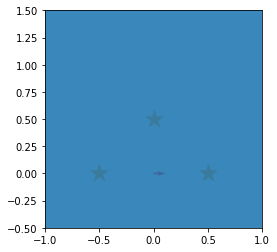

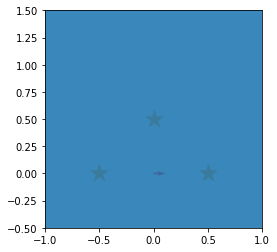

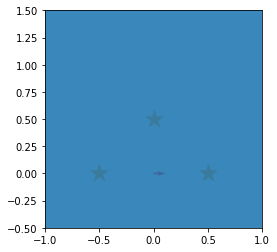

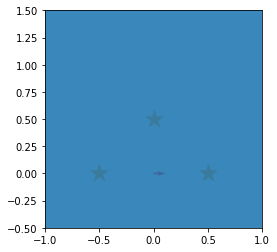

In [ ]:
robot.pose = np.array([0.0,0.0,0.0])   #ロボットの実際の姿勢
slam = FastSLAM(robot.pose)
slam.draw()

### 青いのは画像からはみ出た誤差楕円の色です。 ###

#### 30ステップ後のパーティクル

原点が固定されていないので、推定された誤差楕円を平行、回転移動してどれくらい正確かを考えましょう。

In [ ]:
def one_step(m):
    slam.motion_update(0.2, math.pi / 180.0 * 20, robot)
    robot.pose = robot.motion_model(robot.pose, 0.2, math.pi / 180.0 * 20)
    measurements = robot.observation(m)
    for m in measurements:
        slam.measurement_update(m)

n = 8
for i in range(n):
    one_step(m)

print(str(n) + "step後の地図")
slam.draw(robot)